[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/10-ME/full_search_dense_ME.ipynb)

# Full search dense motion estimation

In [1]:
import numpy as np
import image_3 as frame
import YCoCg as YUV
import motion
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True
!ln -sf ~/MRVC/src/LP.py .
import LP
import cv2 as cv
from common import show_frame
from common import show_vectors
from common import normalize
!ln -sf ~/quantization/information.py .
import information

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


If we extrapolate the idea used in `full_search_block_based_BE()` when the `block_side==1`, there are a huge amount of redundant substractions when adjacent blocks are processed. In the following implementation, the subtractions are performed only once because all the "blocks" (that in this case are of one pixel) are subtracted at each seaching point (one for search area). Another characteristic of this algorithm is that the error frames are smoothed to increase the correlation between the motion vectors.

In [2]:
# Copiado de MRVC/src/motion.py
OVERLAPPING_AREA_SIDE = 17
SEARCH_RANGE = 32
def full_search_dense_ME(P, R, sr=SEARCH_RANGE, oas=OVERLAPPING_AREA_SIDE):
    assert OVERLAPPING_AREA_SIDE % 2 != 0 # This a requirement of cv.GaussianBLur
    extended_R = np.zeros((R.shape[0] + sr, R.shape[1] + sr)) # Ojo, probar extension
    extended_R[sr//2 : R.shape[0] + sr//2, sr//2 : R.shape[1] + sr//2] = R
    MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.int8)
    min_error = np.full((P.shape[0], P.shape[1]), 255, dtype=np.uint8)
    for y in range(sr):
        print(f"{y}/{sr - 1}", end='\r')
        for x in range(sr):
            error = extended_R[y : P.shape[0] + y, x : P.shape[1] + x] - P
            a_error = abs(error) # Ojo probar MSE
            blur_a_error = cv.GaussianBlur(a_error, (oas, oas), 0).astype(np.int)
            which_min = blur_a_error <= min_error
            MVs[:,:,0] = np.where(which_min, x - sr//2, MVs[:,:,0])
            MVs[:,:,1] = np.where(which_min, y - sr//2, MVs[:,:,1])
            min_error = np.minimum(min_error, blur_a_error)
    return MVs.astype(np.float)

## Testing with moving circles (max_abs_motion=1)

In [3]:
R = frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0)
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P = frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 1)
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/001.png (64, 64, 3) uint8 684 


In [4]:
MVs = full_search_dense_ME(P_Y, R_Y, 16, 17)

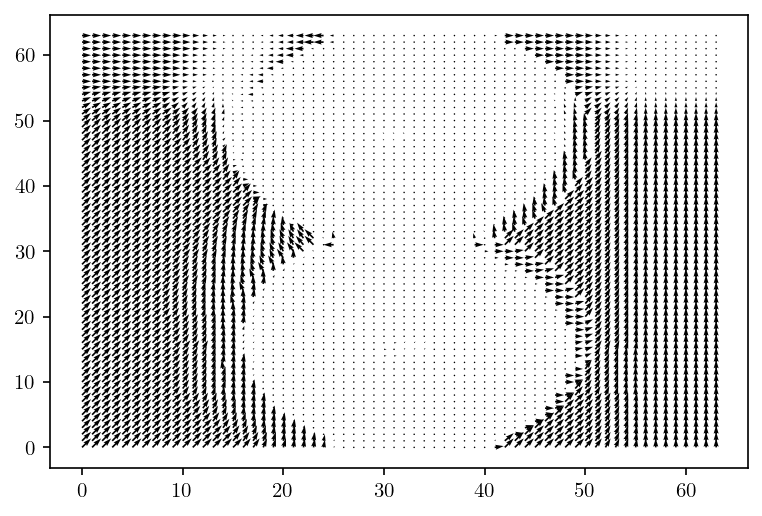

In [5]:
show_vectors(MVs)

In [6]:
hatP = motion.make_prediction(R, MVs.astype(np.float32))

/home/vruiz/Sistemas-Multimedia.github.io/milestones/10-ME/common.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (img-min_component)/max_min_component


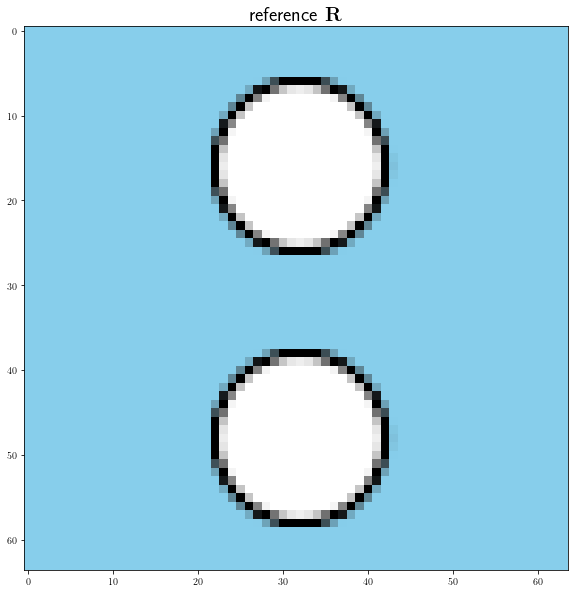

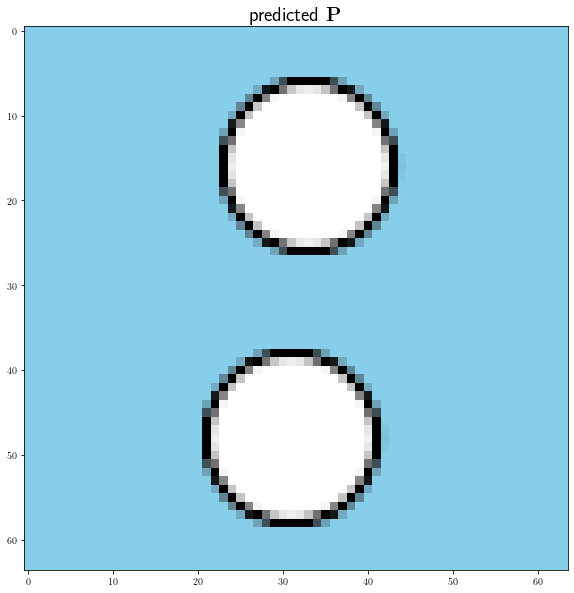

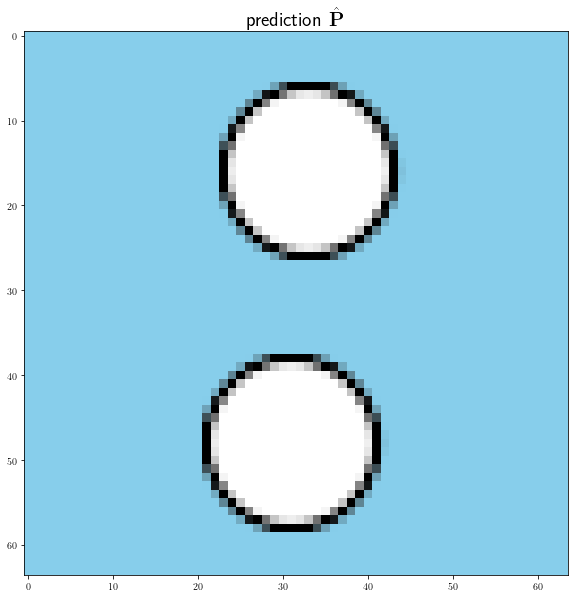

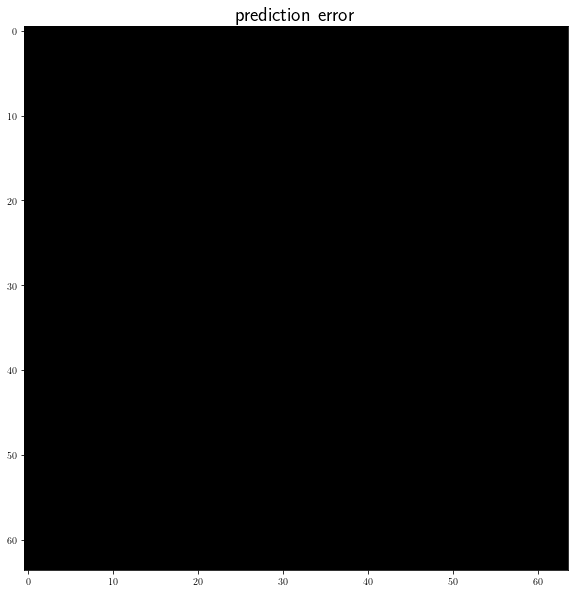

In [7]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")
show_frame(hatP, "prediction $\hat{\mathbf P}$")
show_frame(normalize(hatP - P), "prediction error")

## Testing with moving circles (max_abs_motion=2)

In [8]:
R = frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0)
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P = frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 2)
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/002.png (64, 64, 3) uint8 684 


In [9]:
MVs = full_search_dense_ME(P_Y, R_Y, 16, 17)

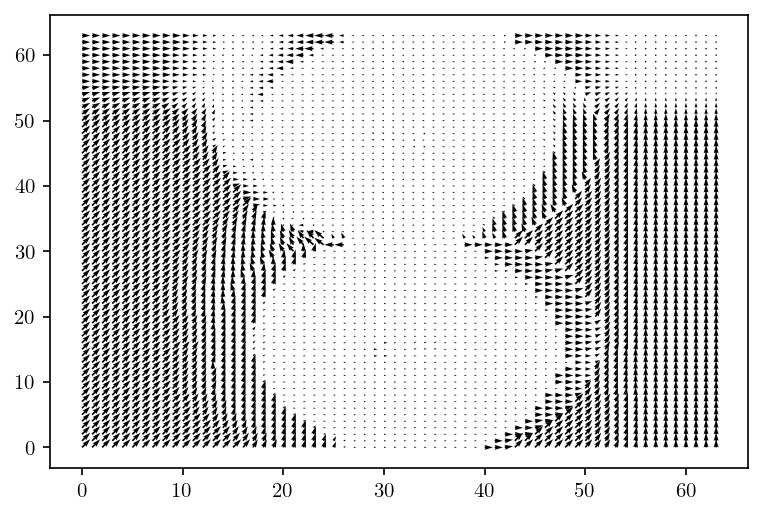

In [10]:
show_vectors(MVs)

In [11]:
hatP = motion.make_prediction(R, MVs.astype(np.float32))

/home/vruiz/Sistemas-Multimedia.github.io/milestones/10-ME/common.py:9: RuntimeWarning: invalid value encountered in true_divide
  return (img-min_component)/max_min_component


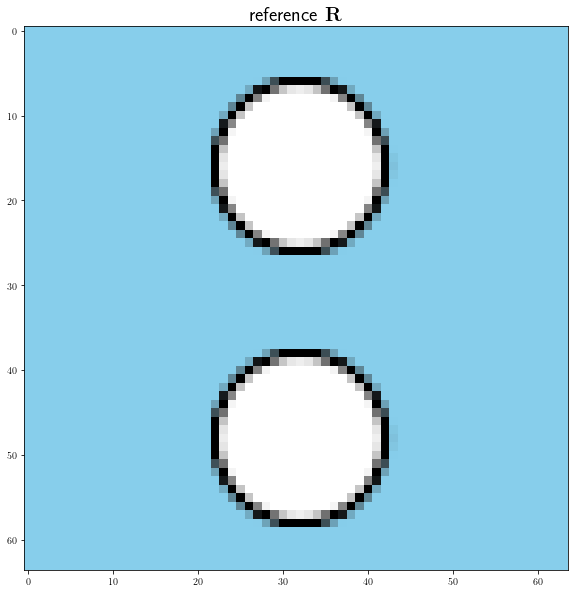

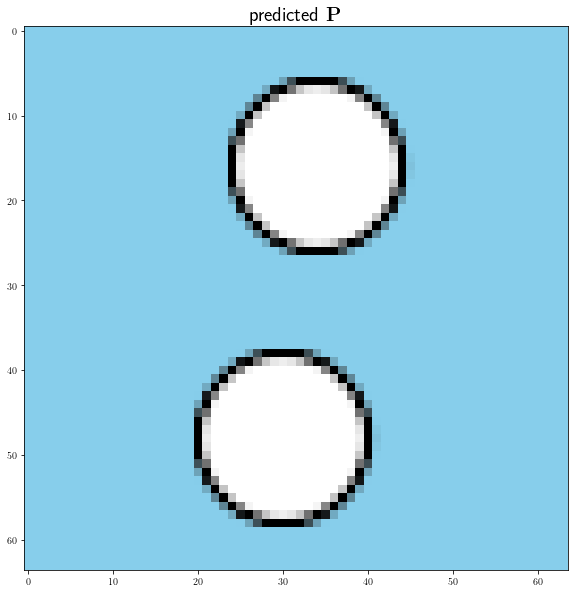

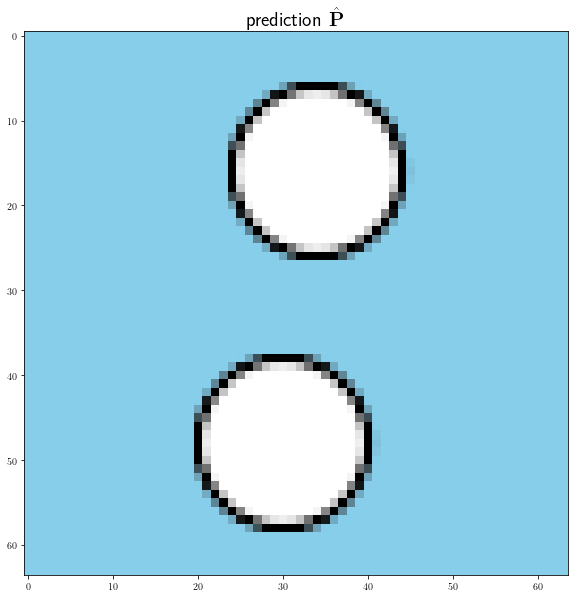

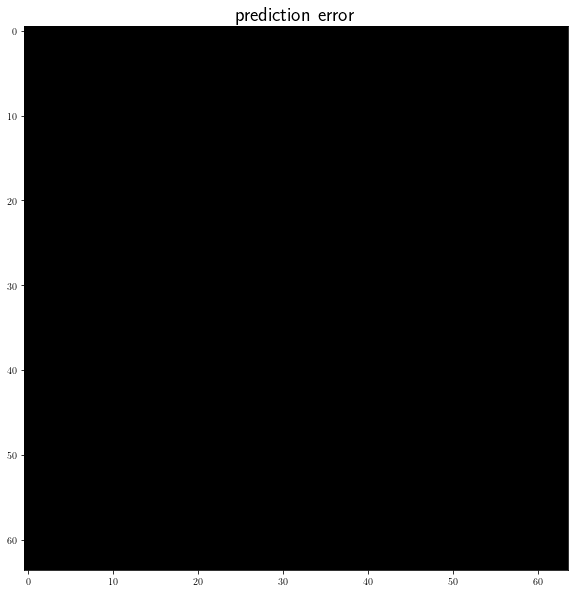

In [12]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")
show_frame(hatP, "prediction $\hat{\mathbf P}$")
show_frame(normalize(hatP - P), "prediction error")

## Testing with mobile

In [13]:
R = frame.read("/home/vruiz/MRVC/sequences/mobile/", 0)
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P = frame.read("/home/vruiz/MRVC/sequences/mobile/", 1)
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/mobile/000.png (486, 720, 3) uint8 953930 
image_3.read: /home/vruiz/MRVC/sequences/mobile/001.png (486, 720, 3) uint8 953584 


In [14]:
MVs = full_search_dense_ME(P_Y, R_Y, 16, 17)

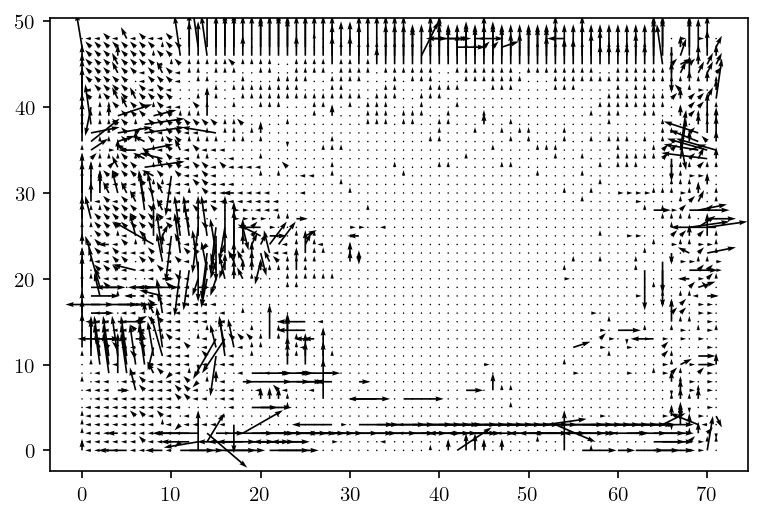

In [15]:
show_vectors(MVs[::10, ::10])

In [16]:
hatP = motion.make_prediction(R, MVs.astype(np.float32))

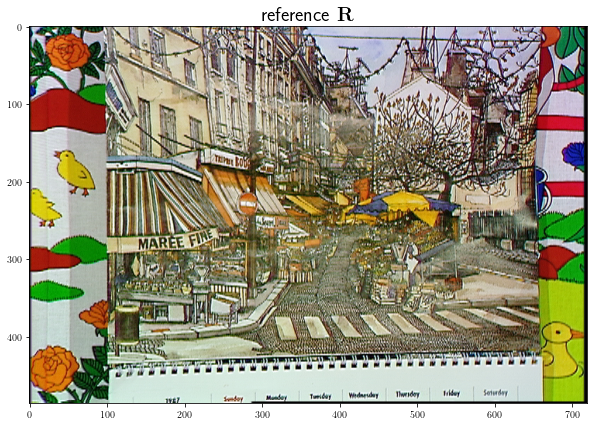

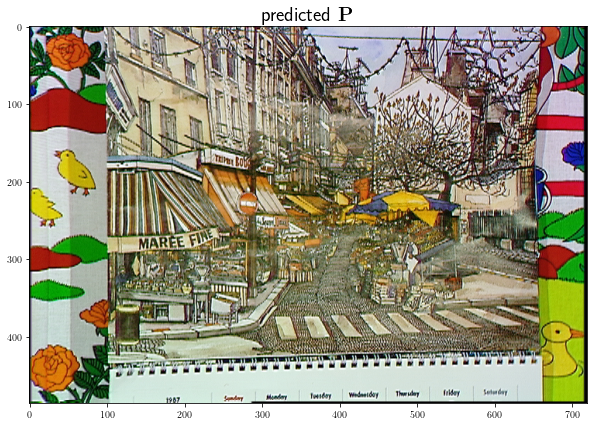

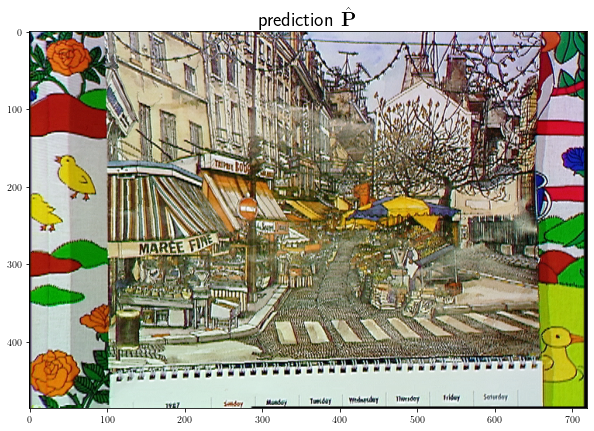

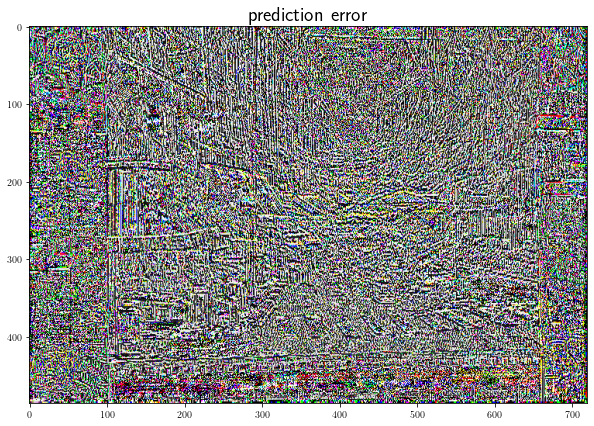

In [17]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")
show_frame(hatP, "prediction $\hat{\mathbf P}$")
show_frame(normalize(hatP - P), "prediction error")

## Testing with bus

In [18]:
R = frame.read("/home/vruiz/MRVC/sequences/bus/", 0)
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P = frame.read("/home/vruiz/MRVC/sequences/bus/", 1)
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/bus/000.png (288, 352, 3) uint8 225840 
image_3.read: /home/vruiz/MRVC/sequences/bus/001.png (288, 352, 3) uint8 225003 


In [19]:
MVs = full_search_dense_ME(P_Y, R_Y, 16, 17)

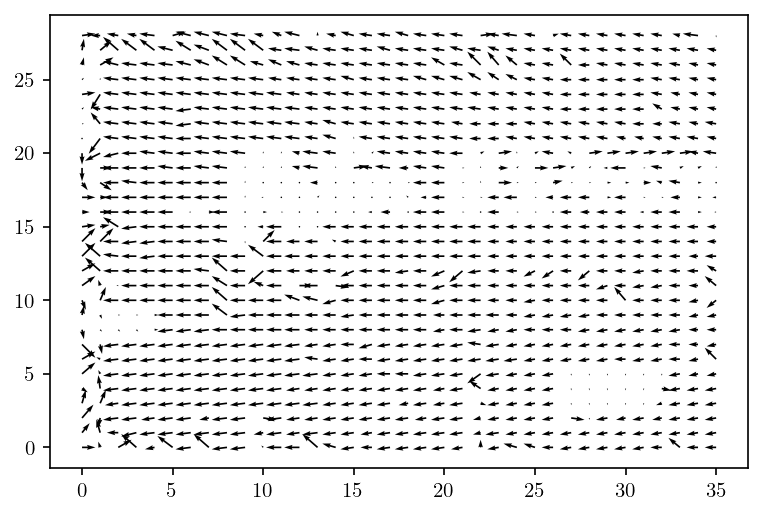

In [20]:
show_vectors(MVs[::10, ::10])

In [21]:
hatP = motion.make_prediction(R, MVs.astype(np.float32))

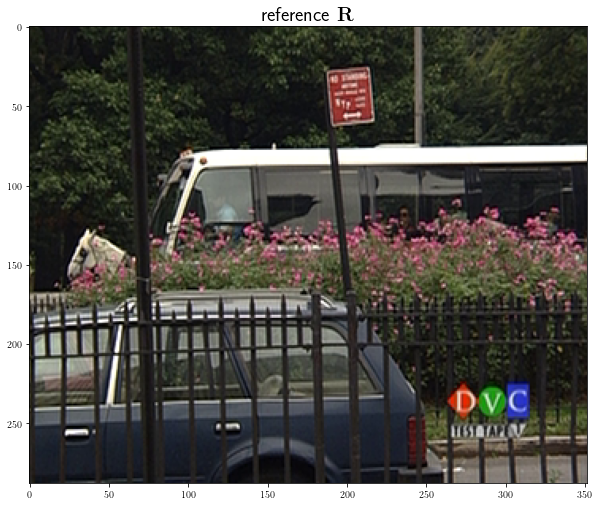

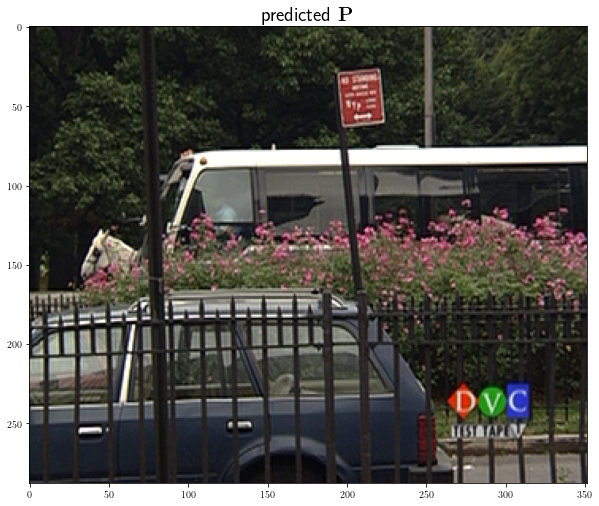

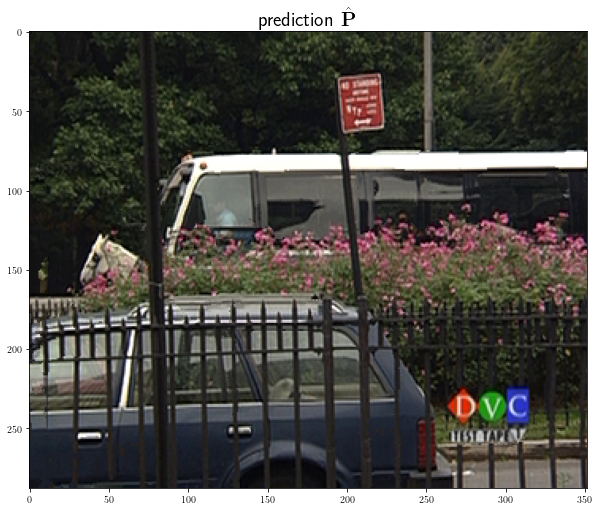

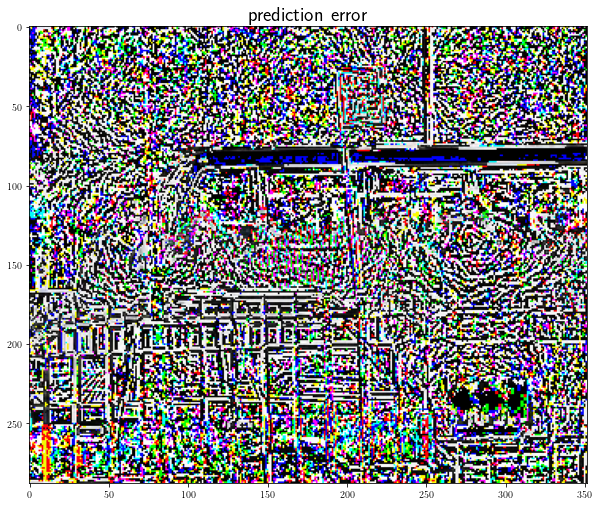

In [22]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")
show_frame(hatP, "prediction $\hat{\mathbf P}$")
show_frame(normalize(hatP - P), "prediction error")

## Testing with a tile of stockholm

In [23]:
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = frame.read(prefix, 0)[100:356,100:612]
P = frame.read(prefix, 1)[100:356,100:612]
R_Y = YUV.from_RGB(R.astype(np.int16))[...,0]
P_Y = YUV.from_RGB(P.astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
image_3.read: /home/vruiz/MRVC/sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 


In [24]:
MVs = full_search_dense_ME(P_Y, R_Y, 16, 17)

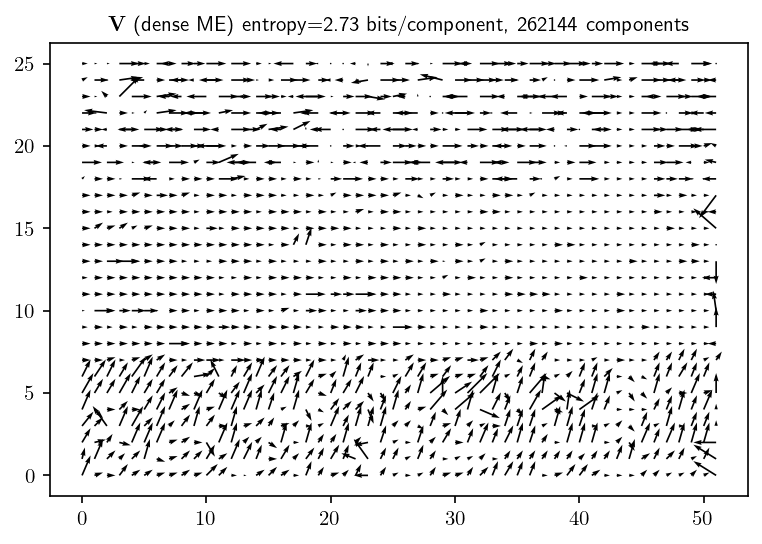

In [25]:
entropy = information.entropy(MVs.flatten())
show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (dense ME) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.size} components")

In [26]:
hat_P = motion.make_prediction(R, MVs.astype(np.float32))

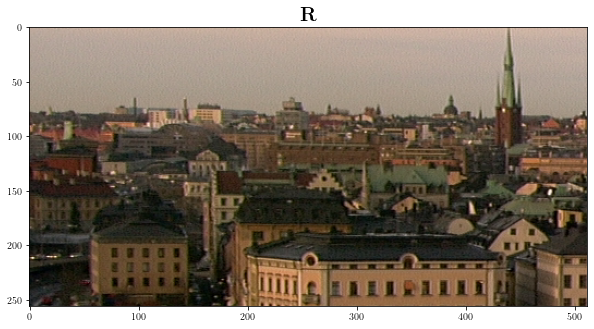

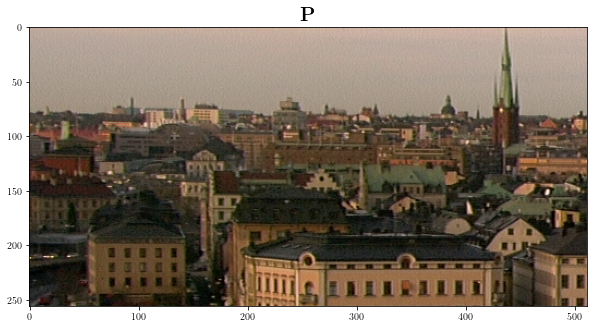

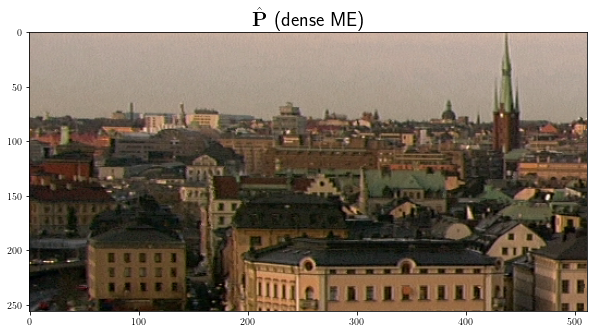

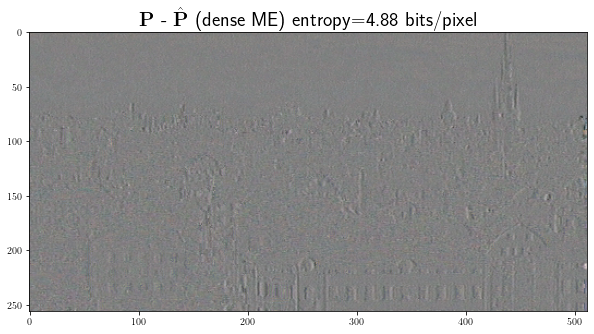

In [27]:
show_frame(R, "${\mathbf R}$")
show_frame(P, "${\mathbf P}$")
show_frame(hat_P, "$\hat{\mathbf P}$ (dense ME)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
show_frame(P_hat_P, "${\mathbf P}$ - $\hat{\mathbf P}$ (dense ME)" + f" entropy={entropy:1.2f} bits/pixel")